In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import json
import numpy as np
import math
from nltk import word_tokenize
import torchtext
from transformers import BertTokenizer, BertModel, BertConfig
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence


batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


141
34
10.12


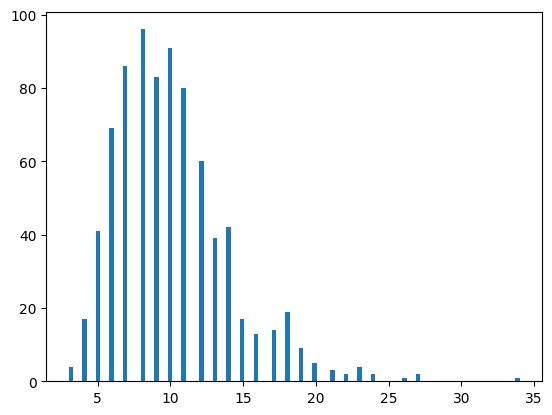

In [2]:
# find the largest sentence length
sent_max_len = 0
max_sent_count = 0
tot_sent_count = 0
num_docs = 0
sent_counts = []
with open('./processed_data/GCDC/Clinton_train.jsonl', 'r') as f:
    for line in f:
        data = json.loads(line)
        num_docs += 1
        sent_count = len(data['sentences'])
        sent_counts.append(sent_count)
        max_sent_count = max(max_sent_count, sent_count)
        tot_sent_count += sent_count
        for sentence in data['sentences']:
            sent_max_len = max(sent_max_len, len(sentence))
print(sent_max_len)
print(max_sent_count)
print(tot_sent_count/num_docs)

# plot the sentence length distribution
plt.hist(sent_counts, bins=100)
plt.show()

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ex_sent = 'This is a test sentence. [SEP] This is another test sentence.'
tokenized_sent = tokenizer(ex_sent, padding='max_length', truncation=True, max_length=20, return_tensors='pt')
print(tokenized_sent)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231, 6251, 1012,  102, 2023, 2003, 2178, 3231,
         6251, 1012,  102,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}


In [4]:
train_data = []
train_inp_file = 'processed_data/GCDC/Clinton_train.jsonl'
with open(train_inp_file, 'r') as f:
    for line in f:
        json_obj = json.loads(line)
        # put [SEP] at the end of each sentence and add each sentence to the list
        for sentence in json_obj['sentences']:
            sentence.append('[SEP]')
        # merge all sentences into one
        document = " ".join([word for sentence in json_obj['sentences'] for word in sentence])
        document = document
        label = json_obj['label']
        train_data.append((document, label-1))

test_data = []
test_inp_file = 'processed_data/GCDC/Clinton_test.jsonl'
with open(test_inp_file, 'r') as f:
    for line in f:
        json_obj = json.loads(line)
        # put [SEP] at the end of each sentence and add each sentence to the list
        for sentence in json_obj['sentences']:
            sentence.append('[SEP]')
        # merge all sentences into one
        document = " ".join([word for sentence in json_obj['sentences'] for word in sentence])
        document = document
        label = json_obj['label']
        test_data.append((document, label-1))

print(len(train_data))
print(train_data[0])
print(train_data[1])
print(train_data[2])
print(len(test_data))
print(test_data[0])

800
('Two options The US views the Transitional National Council as the sole / only legitimate interlocutor of the Libyan people during this interim period , as Libyans come together to plan their own future and a permanent , inclusive constitutional system that protects the rights of all Libyans . [SEP] This is in contrast to the Qadhafi regime , which has lost all legitimacy to rule . [SEP] The US views the Transitional National Council as the legitimate interlocutor of the Libyan people during this interim period , as Libyans come together to plan their own future and a permanent , inclusive constitutional system that protects the rights of all Libyans . [SEP] This is in contrast to the Qadhafi regime , which has lost all legitimacy to rule . [SEP] The INC is the institution through which we are engaging the Libyan people at this time . [SEP]', 2)
("Ambassador , We just received an email from the Adoption Service Provider about these cases . [SEP] I am currently reviewing the files 

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_tokenized = tokenizer([data[0] for data in train_data], padding='max_length', truncation=True, max_length=512, return_tensors='pt')
test_tokenized = tokenizer([data[0] for data in test_data], padding='max_length', truncation=True, max_length=512, return_tensors='pt')

train_labels = torch.tensor([data[1] for data in train_data])
test_labels = torch.tensor([data[1] for data in test_data])

print(train_tokenized['input_ids'].shape)
print(train_tokenized['attention_mask'].shape)
print(train_labels.shape)
print(test_tokenized['input_ids'].shape)
print(test_tokenized['attention_mask'].shape)
print(test_labels.shape)

print(train_tokenized['input_ids'][0])
print(train_tokenized['attention_mask'][0])
print(train_labels[0])
print(test_tokenized['input_ids'][0])
print(test_tokenized['attention_mask'][0])
print(test_labels[0])

train_dataset = TensorDataset(train_tokenized['input_ids'], train_tokenized['attention_mask'], train_labels)
test_dataset = TensorDataset(test_tokenized['input_ids'], test_tokenized['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([800, 512])
torch.Size([800, 512])
torch.Size([800])
torch.Size([200, 512])
torch.Size([200, 512])
torch.Size([200])
tensor([  101,  2048,  7047,  1996,  2149,  5328,  1996, 17459,  2120,  2473,
         2004,  1996,  7082,  1013,  2069, 11476,  6970,  4135, 12690,  2953,
         1997,  1996, 19232,  2111,  2076,  2023,  9455,  2558,  1010,  2004,
        19232,  2015,  2272,  2362,  2000,  2933,  2037,  2219,  2925,  1998,
         1037,  4568,  1010, 18678,  6543,  2291,  2008, 18227,  1996,  2916,
         1997,  2035, 19232,  2015,  1012,   102,  2023,  2003,  1999,  5688,
         2000,  1996,  1053,  4215,  3270,  8873,  6939,  1010,  2029,  2038,
         2439,  2035, 22568,  2000,  3627,  1012,   102,  1996,  2149,  5328,
         1996, 17459,  2120,  2473,  2004,  1996, 11476,  6970,  4135, 12690,
         2953,  1997,  1996, 19232,  2111,  2076,  2023,  9455,  2558,  1010,
         2004, 19232,  2015,  2272,  2362,  2000,  2933,  2037,  2219,  2925,
         1998,

In [6]:
'''
Every document is a list of sentences, separated by [SEP].
The hierarchical model is a two-level model. The first level
is a sentece encoder, and the second level is a document encoder.
The sentence encoder takes individual sentences (separated by
SEP token) as input. The outputs from each position of the last layer
of the sentence encoder are pooled (separately for each sentence) using
pooling strategies. The pooled outputs are then fed into the document
encoder. The document encoder takes the pooled outputs from the sentence
encoder as input. Each sentence in the document is encoded by the 
sentence encoder and passed as input to the document encoder. Finally,
the CLS token's transformed representation from the document encoder is 
fed to a dense layer with ReLU activation which is then connected to a 
task-specific output layer.
'''

"\nEvery document is a list of sentences, separated by [SEP].\nThe hierarchical model is a two-level model. The first level\nis a sentece encoder, and the second level is a document encoder.\nThe sentence encoder takes individual sentences (separated by\nSEP token) as input. The outputs from each position of the last layer\nof the sentence encoder are pooled (separately for each sentence) using\npooling strategies. The pooled outputs are then fed into the document\nencoder. The document encoder takes the pooled outputs from the sentence\nencoder as input. Each sentence in the document is encoded by the \nsentence encoder and passed as input to the document encoder. Finally,\nthe CLS token's transformed representation from the document encoder is \nfed to a dense layer with ReLU activation which is then connected to a \ntask-specific output layer.\n"

In [7]:
# define the sentence encoder
class SentenceEncoder(nn.Module):
    def __init__(self, pooling_strategy):
        super(SentenceEncoder, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.pooling_strategy = pooling_strategy

    def forward(self, input_ids, attention_mask):      
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        if self.pooling_strategy == 'CLS':
            pooled_output = last_hidden_state[:, 0, :]
        elif self.pooling_strategy == 'mean':
            pooled_output = torch.mean(last_hidden_state, dim=1)
        elif self.pooling_strategy == 'max':
            pooled_output = torch.max(last_hidden_state, dim=1)[0]
        else:
            print('Invalid pooling strategy!')
            return None
        return pooled_output
    
# define the document encoder using bert
class DocumentEncoder(nn.Module):
    def __init__(self):
        super(DocumentEncoder, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        pooled_output = last_hidden_state[:, 0, :]
        return pooled_output
    
# define the hierarchical model
class HierarchicalModel(nn.Module):
    def __init__(self, sentence_encoder, document_encoder, num_classes):
        super(HierarchicalModel, self).__init__()
        self.sentence_encoder = sentence_encoder
        self.document_encoder = document_encoder
        self.num_classes = num_classes
        self.dense = nn.Linear(768, 768)
        self.relu = nn.ReLU()
        self.output = nn.Linear(768, self.num_classes)

    def forward(self, input_ids, attention_mask):
        # shape of input_ids: (batch_size, max_doc_length)
        # shape of attention_mask: (batch_size, max_doc_length)
        # first, we must pass each sentence separately to the sentence encoder
        # each sentence in the document is separated by [SEP]
        # we must find the indices of [SEP] tokens in the input_ids and attention_mask of each document
        
        


        # # first, we must pass each sentence separately to the sentence encoder
        # # each sentence in the document is separated by [SEP]
        # # we must find the indices of [SEP] tokens in the input_ids
        # sep_indices = torch.nonzero(input_ids == 102)
        # # divide the input_ids and attention_mask into sentences
        # # each sentence is a list of tokens
        # input_ids = torch.split(input_ids, sep_indices.shape[0])
        # attention_mask = torch.split(attention_mask, sep_indices.shape[0])
        # # remove the [SEP] token from the end of each sentence
        # input_ids = [sentence[:-1] for sentence in input_ids]
        # attention_mask = [sentence[:-1] for sentence in attention_mask]
        # # pad each sentence to the same length
        # input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
        # attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
        # # shape of input_ids: (batch_size, max_num_sentences, max_sentence_length)
        # # pass each sentence to the sentence encoder
        # sentence_embeddings = self.sentence_encoder(input_ids[:, 0, :], attention_mask[:, 0, :])
        # for i in range(1, input_ids.shape[1]):
        #     sentence_embeddings = torch.cat((sentence_embeddings, self.sentence_encoder(input_ids[:, i, :], attention_mask[:, i, :])), dim=1)
        # # shape of sentence_embeddings: (batch_size, max_num_sentences, 768)
        # # pass the sentence embeddings to the document encoder
        # document_embeddings = self.document_encoder(sentence_embeddings, attention_mask[:, 0, :])
        # # shape of document_embeddings: (batch_size, 768)
        # # pass the document embeddings to the dense layer
        # dense_output = self.dense(document_embeddings)
        # dense_output = self.relu(dense_output)
        # # pass the dense output to the output layer
        # output = self.output(dense_output)
        # return output
    
        


In [8]:
# hyperparameters
learning_rate = 0.001
num_epochs = 10
num_classes = 3

# define the model
sentence_encoder = SentenceEncoder(pooling_strategy='mean')
document_encoder = DocumentEncoder()
model = HierarchicalModel(sentence_encoder, document_encoder, num_classes=num_classes)
model.to(device)

# define the loss function
loss_function = nn.CrossEntropyLoss()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.pred

In [9]:
# train the model
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch[0].to(device)
        # print(input_ids.shape)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        # forward pass
        outputs = model(input_ids, attention_mask)
        loss = loss_function(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))


torch.Size([54, 2])


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not NoneType

In [ ]:
# evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy: {}%'.format(correct / total * 100))

# save the model
torch.save(model.state_dict(), 'hierarchical_model.pth')